# Exercise 7: Sinusoidal plus residual model

1. Window type (`window`) and Window size (`M`): The choice of window size and window type has a time-frequency trade-off. Choosing a longer window helps resolve sinusoidal components that are close in frequency, but gives a poorer temporal resolution. Shorter windows track transients better, maintaining sharp onsets, but may not resolve frequency components so well. For monophonic harmonic sounds, the window size is best chosen based on the lowest value of f0 and the fastest change in pitch.
2. FFT size (`N`): The FFT size is chosen as a power of 2 larger than the window size M. A large FFT size N, compared with M, results on an interpolated DFT spectrum and leads to better estimation of spectral peak values. However, given that the software also uses parabolic interpolation we can achieve good peak estimates with not too big FFT sizes, for example just the next power of 2 larger than M.
3. Threshold in negative dB (`t`): The peak picking threshold is the lowest amplitude peak that will be identified. Setting a very low threshold ($<-120$dB) will take most peaks, but the threshold should be set as high as possible to minimize the presence of peaks that do not correspond to sinusoidal peaks (the window main-lobe).
4. Maximum number of harmonics (`nH`): The maximum number of harmonics that can be detected in a harmonic sound is influenced by the brightness of the sound, but also by the sampling rate and by how low is the f0. The recording quality can also have an impact. For a compact representation, we should only capture the relevant harmonics, the ones that affect the perceptual quality of the reconstruction.
5. Minimum f0 frequency in Hz (`minf0`) and Maximum f0 frequency in Hz (`maxf0`): The `minf0` and `maxf0` are the parameters used by the fundamental frequency detection algorithm to obtain possible `f0` candidates to be passed to the TWM algorithm. Choosing a correct range of `f0`, but the smallest possible, greatly improves the `f0` estimation by TWM algorithm, specially minimizing octave errors, which are very common in `f0` detection algorithms. You should select the values by first looking at the spectrogram of the sound and identifying the lowest and highest fundamental frequencies present.
6.  Threshold in the f0 detection (`f0et`): This is the maximum error allowed in the TWM algorithm. If the value is too large, the algorithm might detect fundamental frequencies that might not be actually so. Instead, if is it too small, good fundamental frequencies might not be detected, returning value 0 at that frame. The smaller the value the more restrictive the algorithm behaves. A normal strategy is to start with a big value ($> 10$) and then making it smaller until we only keep what we consider to be the relevant f0 components, discarding the \texttt{f0} values in the parts of the sound that do not have a clear harmonic structure.
7. Slope of harmonic deviation (`harmDevSlope`): Slope of the harmonic deviation allowed in the estimated harmonic frequencies, compared to a perfect harmonic frequencies. If the value is 0 it means that we allow the same deviation for all harmonics, which is hard coded to \texttt{f0}$/3$. A value bigger than 0 means that higher harmonics will be allowed to deviate more than the lower harmonics from perfect harmonicity (which is a common behaviour). It normally works better to have a value slightly bigger than 0, for example around 0.01.
8. Minimum length of harmonics (`minSineDur`): Any harmonic track shorter, in seconds, than minSineDur will be removed. This is a good parameter for discarding harmonic tracks that are too short and thus that do not correspond to stable harmonics of the sound. Typically we put a value bigger that 0.02 seconds.
9. Decimation factor of magnitude spectrum for stochastic analysis (`stocf`): The stochastic approximation of the residual is a decimated version of the magnitude spectrum of the residual. This leads to a compact and smooth function that approximates the magnitude spectrum of the residual at each frame. The smaller the stocf, higher the decimation will be and thus will result in a more compact representation. A value of 1 means no decimation, leaving the residual magnitude spectrum as it is. A value of 0.2 (a good starting value) will decimate the original residual magnitude spectrum by a factor of 1/5.

The most compact and useful representation of a sound, least number of analysis data values while maintaining the sound quality in the synthesis, will be obtained by using a high t, a small `nH`, a small decimation factor for stochastic analysis, stocf, and by succeeding in detecting only the harmonics they are perceptually relevant. The values of `nH`, `minf0` and `maxf0` should be chosen by first visualizing the spectrogram of the sound with a large enough window size. There is usually a range of all parameter values for which we get a good reconstruction. Also the analysis parameters are not independent of each other and hence they need to be considered together. For testing if the detection of the harmonics have been done correctly (and for improving it) it is very useful to perform the Harmonic plus Residual analysis/synthesis (HPR model) using the same parameters and listen to the residual component for possible artifacts resulting from the harmonic analysis.

## Part 1. Obtain a good harmonic+stochastic analysis of a speech sound




In [ ]:
import numpy as np
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd

from smstools.models import utilFunctions as UF
from smstools.models import stft as STFT
from smstools.models import hpsModel as HPS
from smstools.models import hprModel as HPR
import IPython.display as ipd

Text(0.5, 1.0, 'magnitude spectrogram')

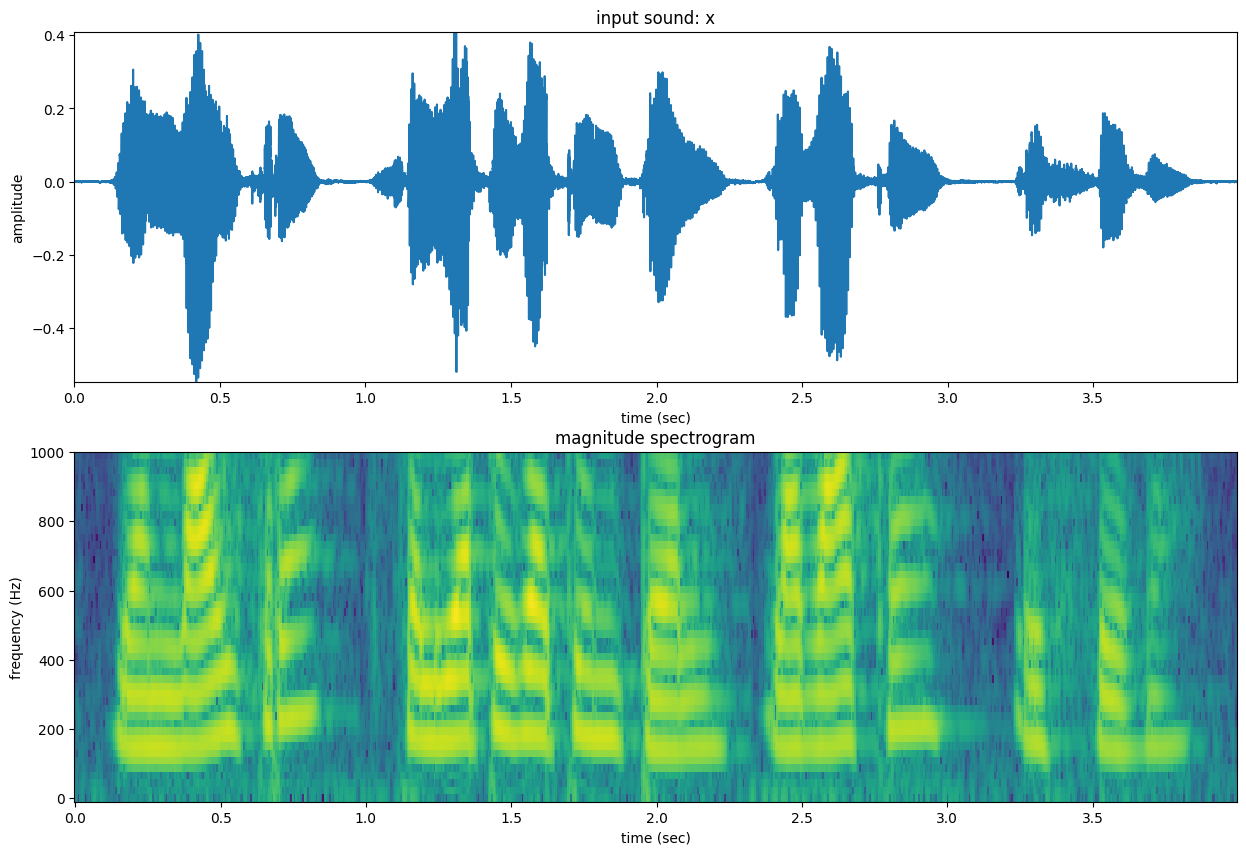

In [ ]:

input_file = 'speech-female.wav'

### set parameters
window = 'hamming'
M = 1046
N = 2048 #improves the visualization
H = 256

    
# no need to modify anything after this
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 10))
maxplotfreq = 1000.0

# plot input sound
plt.subplot(2,1,1)
plt.plot(np.arange(x.size)/float(fs), x)
plt.axis([0, x.size/float(fs), min(x), max(x)])
plt.ylabel('amplitude')
plt.xlabel('time (sec)')
plt.title('input sound: x')

# plot magnitude spectrogram
plt.subplot(2,1,2)
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')

In [ ]:

input_file = 'speech-female.wav'

### fill the parameters
window ='hamming'
M = 1024
N = 2048 
t = -80
minSineDur = 0.01
nH = 10 
minf0 = 100
maxf0 = 250
f0et = 5
harmDevSlope = 0.2 #high bc its for speech
stocf = 0.1

# no need to modify anything after this
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))



In this laboratory, we are synthesizing speech, where achieving better temporal resolution is more imporatant than frequency resolution. The chosen parameters align with this requirement.

To achieve this, I selected a Hamming window, as it reduces spectral leakage while maintaining good frequency resolution. The window size is 1024, which provides a better time resolution, and the FFT size is 2048, ensuring clear spectrogram visualization, which helps in determining other key parameters.

The threshold is set to -80 dB, meaning that only spectral peaks above this amplitude are considered. This helps filter out noise, and the value was determined by examining the signal's spectrum.

The minimum sine duration is set to 0.1 seconds, ensuring that only stable harmonics lasting longer than this duration are retained. This value was chosen based on the duration of the shortest distinguishable tone.

The number of harmonics is set to 10, capturing only well-defined and energetic harmonics. This value was determined by analyzing the spectrogram and counting the number of clearly distinguishable harmonics.

The minimum and maximum fundamental frequencies (minf0 and maxf0) were selected based on the fundamental frequency range of the woman’s voice, ensuring accurate pitch detection.

For f0 detection (f0et), a small value was chosen, as the harmonics are very close together, requiring a precise estimation of the fundamental frequency.

The harmonic deviation slope (harmDevSlope) is set to 0.2, allowing harmonics to deviate from exact integer multiples of f0. This is important for speech, as natural variations in harmonicity are common.

Finally, the stochastic decimation factor (stocf) is set to 0.1, meaning the residual spectrum is significantly decimated to create a smooth and compact representation of the stochastic component.

## Part 2. Obtain a good harmonic+stochastic analysis of a monophonic musical phrase



In [ ]:

#### your code here
input_file = 'monophonic.wav'
(fs, x) = UF.wavread(input_file)
ipd.display(ipd.Audio(data=x, rate=fs))

C:\Users\aina0\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\smstools\models\utilFunctions.py:69: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs, x = read(filename)




The selected sound is a short melody played on an electric keyboard, accompanied by some background noise. It features the first five notes of the *101 Dalmatians* film theme.

Text(0.5, 1.0, 'magnitude spectrogram')

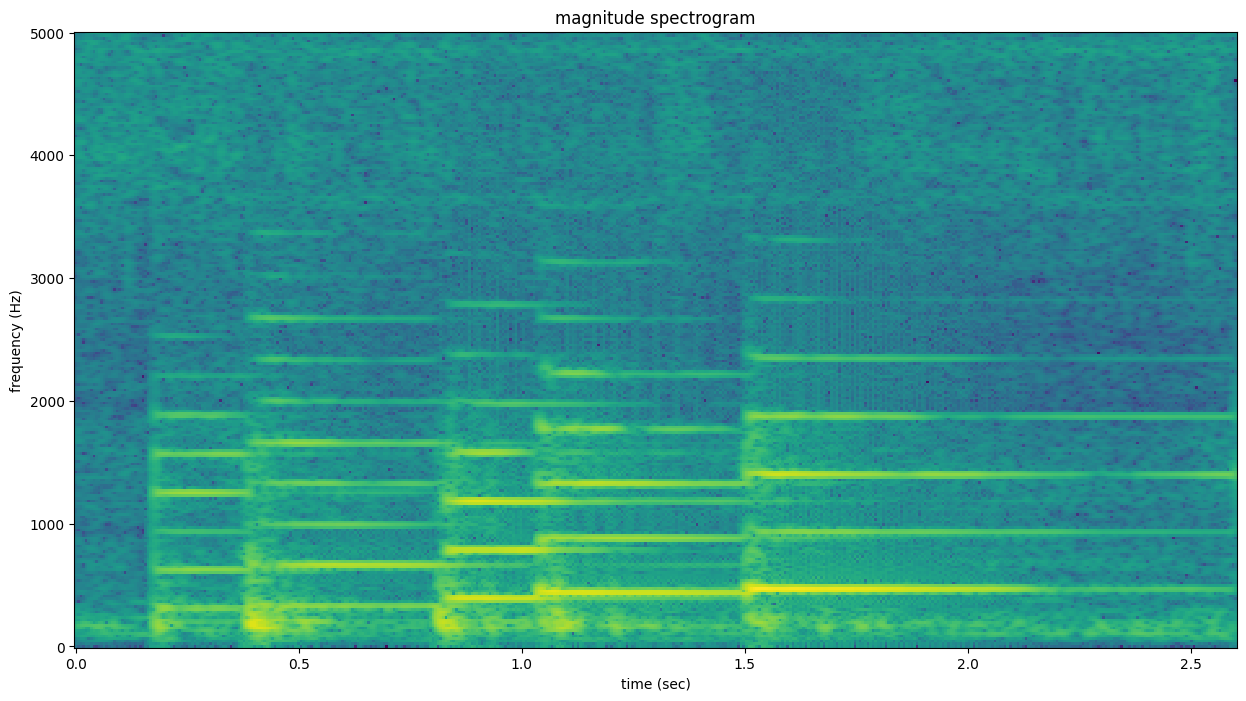

In [ ]:

### basic visualization and listening of sound
input_file = 'monophonic.wav'
window = 'hamming'
M = 2048
N = 2048
H = 256

# no need to modify anything after here
fs, x = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
mX, pX = STFT.stftAnal(x, w, N, H)

ipd.display(ipd.Audio(data=x, rate=fs))

plt.figure(figsize=(15, 8))
maxplotfreq = 5000.0
numFrames = int(mX[:,0].size)
frmTime = H*np.arange(numFrames)/float(fs)
binFreq = fs*np.arange(N*maxplotfreq/fs)/N
plt.pcolormesh(frmTime, binFreq, np.transpose(mX[:,:int(N*maxplotfreq/fs+1)]))
plt.xlabel('time (sec)')
plt.ylabel('frequency (Hz)')
plt.title('magnitude spectrogram')


To apply Harmonic Plus Stochastic (HPS) analysis and synthesis, we need a monophonic sound with noise. This model separates the harmonic content from the noise, where the stochastic part approximates the residual noise after extracting the harmonics. This improves analysis accuracy and allows for a more natural synthesis of the sound.

The chosen sound is monophonic, as the melody consists of a single-note sequence, making it well-suited for HPS analysis.

Additionally, the sound has a strong harmonic structure since it is produced by an electric keyboard, meaning each note contains a fundamental frequency (f0) and its harmonics.

Finally, there is significant background noise, which contributes to the stochastic component of the model. This noise will be captured and modeled separately, ensuring a more accurate representation of both the harmonic and non-harmonic elements of the sound.

In [ ]:


### fill the parameters
input_file = 'monophonic.wav'
window ='blackman'
M = 2048
N = 2048
t = -80
minSineDur = 0.2
nH = 8 
minf0 = 100
maxf0 = 450
f0et = 10
harmDevSlope = 0.01
stocf = 0.1

# No need to modify
Ns = 512
H = 128

(fs, x) = UF.wavread(input_file)
w = get_window(window, M, fftbins=True)
hfreq, hmag, hphase, stocEnv = HPS.hpsModelAnal(x, fs, w, N, H, t, nH, minf0, maxf0, f0et, harmDevSlope, minSineDur, Ns, stocf)
y, yh, yst = HPS.hpsModelSynth(hfreq, hmag, hphase, stocEnv, Ns, H, fs)

ipd.display(ipd.Audio(data=x, rate=fs))
ipd.display(ipd.Audio(data=y, rate=fs))



As in previous exercises, I chose a Blackmann window because it reduces spectral leakage while maintaining good frequency resolution, and it's better for the analysis of music. Since this is a melody, frequency resolution is more important than temporal resolution, that's why I set the M to 2048.

I set the FFT size to 2048 to ensure a clear spectrogram visualization, allowing better selection of the following parameters

The threshold is set to -80 dB, meaning only spectral peaks above this amplitude are considered. This value was chosen by examining the spectral representation of the signal.

The minimum sine duration is set to 0.2 seconds, ensuring that only stable harmonics lasting longer than 0.2 seconds are retained. This was determined by analyzing the duration of the shortest note in the melody.

The number of harmonics (nH = 8) was selected by counting the most energetic harmonics visible in the spectrogram, ensuring that only relevant harmonics are considered.

The minimum and maximum fundamental frequencies (minf0 = 100, maxf0 = 450) are based on the range of the most energetic harmonics present in the sound.

I set a relatively large f0 error threshold (f0et=10) because the harmonics are widely spaced. This prevents missing fundamental frequencies, ensuring a more reliable detection.

The harmonic deviation slope (harmDevSlope = 0.1) is small, as observed in the spectrogram, where higher harmonics deviate slightly from perfect harmonicity.

Finally, I set a low stochastic factor (stocf = 0.1), ensuring that the stochastic component is highly smoothed and does not capture unnecessary noise details.

The result is not as perfect as for the woman's speech. However, the analysis is accurate, with only a slight approximation error on the last long note.